<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/Neural_Network_Base_Model_separate_stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyod --quiet

     |████████████████████████████████| 134 kB 7.1 MB/s 


In [3]:
!unzip /content/drive/MyDrive/SWaT_Dataset_v0.zip -d /content/

Archive:  /content/drive/MyDrive/SWaT_Dataset_v0.zip
  inflating: /content/SWaT_Dataset_Attack_v0.csv  
  inflating: /content/SWaT_Dataset_Normal_v0.csv  


In [4]:
import numpy as np
import os
import pandas as pd
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pickle
import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
import pyod
import seaborn as sns
import timeit
from sklearn.metrics import confusion_matrix

Data Pre-processing

In [5]:
swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [6]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_attack.columns.str.replace(' ','')

In [7]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [8]:
test_df = swat_attack.set_index('Timestamp')
test_df['label'] = np.where(test_df['Normal/Attack'] == 'Attack', 1, 0)

test_df = test_df.drop('Normal/Attack', axis=1)

train_df = swat_normal.set_index('Timestamp')
train_df['label'] = np.where(train_df['Normal/Attack'] == 'Attack', 1, 0)
train_df = train_df.drop('Normal/Attack', axis=1)

# trim start stage
train_df = train_df.iloc[21600:]


In [9]:
train_df.drop(columns = 'label',inplace = True)
label = test_df['label'].values
test_df.drop(columns = 'label',inplace = True)

In [10]:
#normalise data
scaler = MinMaxScaler()
scaler = scaler.fit(train_df)

In [11]:
train_scale = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns= train_df.columns
)

test_scale  = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns= test_df.columns
)

In [12]:
train_scale.shape ,test_scale.shape

((475200, 51), (449919, 51))

In [13]:
train_df.columns

Index(['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202',
       'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205',
       'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303',
       'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401',
       'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504',
       'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603'],
      dtype='object')

In [14]:
P1 = ['FIT101', 'LIT101', 'MV101', 'P101', 'P102']
P2 = ['AIT201', 'AIT202','AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206']
P3 = ['DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302']
P4 = ['AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401']
P5 = ['AIT501', 'AIT502', 'AIT503', 'AIT504','FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503']
P6 = ['FIT601', 'P601', 'P602', 'P603']

Model Prediction on each stage

In [15]:
from  pyod.models.deep_svdd import DeepSVDD
model = DeepSVDD(preprocessing = False,epochs=100, batch_size=64, hidden_neurons=[64, 32])

In [16]:
def get_test_score(stage,train_scale,test_scale):
  norm_test_scores = []
  test_scores = []
  train_scores = []
  norm_train_scores = []
  trainning_time = []
  prediction_time = []

  for i in stage:
    start = timeit.default_timer()
    model.fit(train_scale[i])
    end = timeit.default_timer()

    train_score = model.decision_scores_
    start_pred = timeit.default_timer()
    test_score = model.decision_function(test_scale[i])
    end_pred = timeit.default_timer()

    test_scores.append(test_score)
    train_scores.append(train_score)

    trainning_time.append(end-start)
    prediction_time.append(end_pred-start_pred)

    #normalise train&test score
    min_train = min(train_score)
    max_train = max(train_score)
    norm_train = (train_score-min_train)/(max_train-min_train)
    norm_test = (test_score - min_train)/(max_train-min_train)

    norm_test_scores.append(norm_test)
    norm_train_scores.append(norm_train)

    print(f"------ Finish Stage {i} ------")
  return norm_test_scores,test_scores,train_scores,norm_train_scores,trainning_time,prediction_time


In [17]:
stage = [P1,P2,P3,P4,P5,P6]

In [18]:
norm_test_scores,test_scores,train_scores,norm_train_scores,trainning_time,prediction_time = get_test_score(stage,train_scale,test_scale)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_1 (Dense)             (None, 64)                320       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 32)               0         
 bda)                                                            
                                                                 
 tf.math.pow_1 (TFOpLambda)  (None, 32)                0         
                                                                 
 tf.math.reduce_sum_1 (TFOpL  (None,)                  0         
 ambda)                                                    

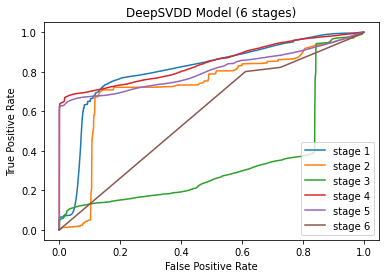

In [19]:
aucs = []
for i in range(len(norm_test_scores)):
  fpr, tpr, _ = metrics.roc_curve(label,  test_scores[i])
  auc = metrics.roc_auc_score(label,  test_scores[i])
  aucs.append(auc)
  plt.plot(fpr,tpr,label=f"stage {i+1}")
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title(f'DeepSVDD Model (6 stages)')
  plt.legend(loc=4)

In [20]:
for i in range(len(aucs)):
  print(f"AUC stage{i+1}: {np.round(aucs[i],3)}, training time = {trainning_time[i]}, prediction_time = {prediction_time[i]}")

AUC stage1: 0.813, training time = 1433.477891167, prediction_time = 15.885858706000135
AUC stage2: 0.728, training time = 1366.3430925080002, prediction_time = 16.188696763999815
AUC stage3: 0.346, training time = 1388.3268618370003, prediction_time = 16.006706151999424
AUC stage4: 0.846, training time = 1410.6166519090002, prediction_time = 16.447411797999848
AUC stage5: 0.807, training time = 1474.6116891800002, prediction_time = 16.308685479000815
AUC stage6: 0.587, training time = 1523.2404585400009, prediction_time = 16.192112132999682


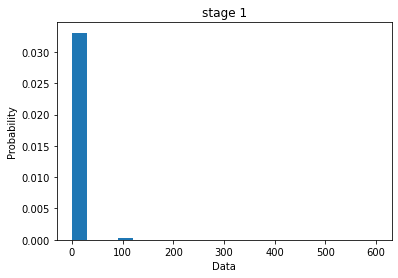

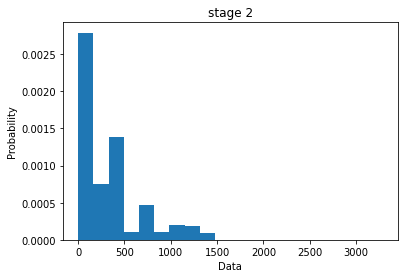

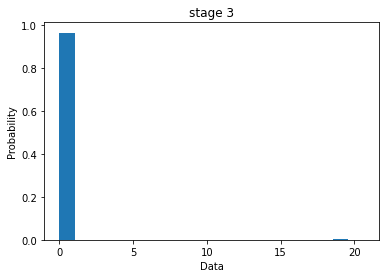

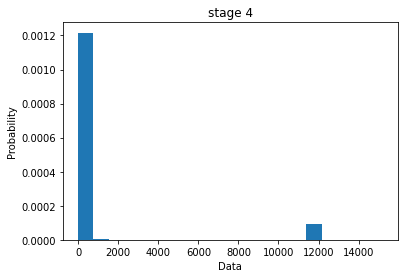

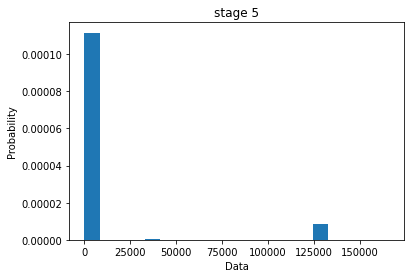

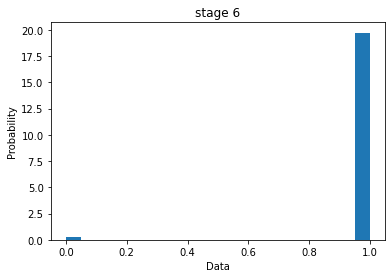

In [21]:
for i in range(len(norm_test_scores)):
  plt.hist(norm_test_scores[i], density=True, bins=20)  # density=False would make counts
  plt.ylabel('Probability')
  plt.xlabel('Data')
  plt.title(f'stage {i+1}')
  plt.show()

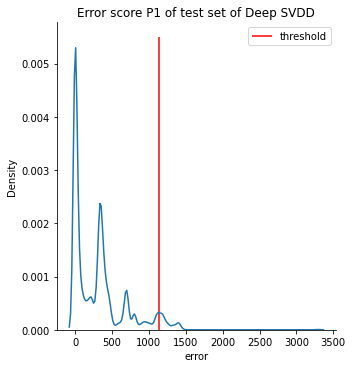

In [146]:
df_score_1 = pd.DataFrame(norm_test_scores[0],columns = ['error'])
sns.displot(df_score_1, x="error",kind="kde")
plt.title("Error score P1 of test set of Deep SVDD")
plt.vlines(np.percentile(norm_test_scores[0],95), ymin = 0, ymax=0.0055,color='red',label="threshold")
plt.legend()
plt.show()

In [23]:
def pred_labels_timewindow(df,threshold,time_window):
  n_data = len(df)
  pred_label = np.array([_ for _ in range(n_data)])
  for i in range(0,n_data-time_window+1):
    if (df[i:i+time_window] >= threshold).any():
      pred_label[i:i+time_window] = 1
    else:
      pred_label[i:i+time_window] = 0

  return pred_label

In [24]:
time_window = 1

##Ture Attack point

In [25]:
true_anomaly = pd.read_csv("/content/drive/MyDrive/Data_sci_Project/List_of_attacks_Final.csv")

In [26]:
true_attack = true_anomaly[~true_anomaly["End Time"].isnull()]

In [27]:
true_attack.tail(3)

,Attack #,Start Time,End Time,Attack Point,Start State,Attack,Actual Change,Expected Impact or attacker intent,Unexpected Outcome
38,39,2/01/2015 11:43:48,11:50:28,"FIT-401, AIT-502",In Normal Range,Set value of FIT-401 as 0.5; Set value of AIT-...,No,UV will shut down and water will go to RO,UV did not shutdown
39,40,2/01/2015 11:51:42,11:56:38,FIT-401,In Normal Range,Set value of FIT-401 as 0,No,UV will shut down and water will go to RO,"P-402 did not close, both should be interlinked"
40,41,2/01/2015 13:13:02,13:40:56,LIT-301,Water level between L and H,decrease value by 0.5 mm per second,No,Tank overflow,Rate of decrease in water level reduced after ...


In [28]:
start_time = true_attack['Start Time']
start_time = pd.to_datetime(start_time)
start_time.loc[36:40] = start_time.loc[36:40]+pd.DateOffset(years=1)

In [29]:
end_time = pd.to_datetime(true_anomaly['End Time'][~true_anomaly["End Time"].isnull()])

In [30]:
attack_lenght = (end_time - pd.to_datetime([str(a) for a in start_time.dt.time])).dt.seconds

In [31]:
len(start_time) #there are 36 attack

36

In [32]:
start_time.index.values+1

array([ 1,  2,  3,  4,  6,  7,  8, 10, 11, 13, 14, 16, 17, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41])

In [33]:
time_label = pd.DataFrame(label, index =  test_df.index.values, columns = ["label"])
time_label.reset_index(inplace=True)
time_label.rename(columns = {'index':'Timestamp'}, inplace = True)
time_label['Timestamp'] = pd.to_datetime(time_label['Timestamp'])

In [34]:
#find start index/ end index of attack
idx_start = time_label[time_label['Timestamp'].isin(start_time)]['Timestamp'].index.values 
idx_end = idx_start+attack_lenght.values

In [35]:
time_label['attack #'] = 0
for i in range (len(idx_start)):
  time_label['attack #'].loc[idx_start[i]:idx_end[i]] = attack_lenght.index.values[i]+1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##tunning threshold from stage P1

In [36]:
!pip install ghostml --quiet

In [37]:
import ghostml
n_percentile = [np.percentile(norm_test_scores,i) for i in range(95,100,1)]

In [38]:
threshold1 = ghostml.optimize_threshold_from_predictions(label, norm_test_scores[0], n_percentile, ThOpt_metrics = 'Kappa') 

In [39]:
threshold1

695.8931884765625

In [40]:
n_percentile #percentil 95

[695.8931884765625,
 913.8966674804688,
 1199.1610107421875,
 11446.880097656249,
 126820.28125]

##Stage P1

In [149]:
t1 = np.percentile(norm_test_scores[0],95)

In [150]:
label_1 = pred_labels_timewindow(norm_test_scores[0],t1,time_window)

In [151]:
time_label["pred_1"] = label_1

In [152]:
att_p1 = time_label[time_label['attack #'].isin([1,2,3,21,26,30,33,34,35,36])]

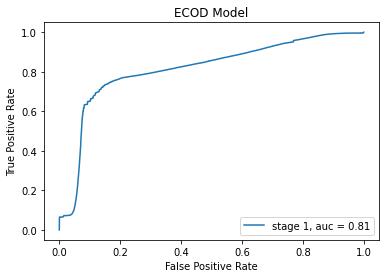

In [153]:
fpr, tpr, _ = metrics.roc_curve(label, norm_test_scores[0])
auc = metrics.roc_auc_score(label, norm_test_scores[0])
plt.plot(fpr,tpr,label=f"stage 1, auc = {np.round(auc,2)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title(f'ECOD Model')
plt.legend(loc=4)

In [154]:
print(metrics.classification_report(label,label_1))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93    395298
           1       0.41      0.07      0.12     54621

    accuracy                           0.87    449919
   macro avg       0.65      0.53      0.52    449919
weighted avg       0.83      0.87      0.83    449919



[[389981   5317]
 [ 50928   3693]]


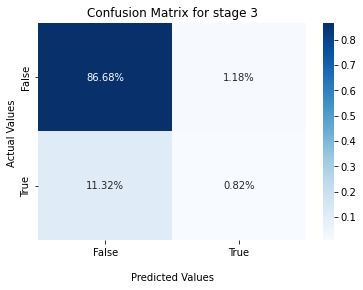

In [155]:
cm = confusion_matrix(label,label_1)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 3');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [156]:
print(metrics.classification_report(att_p1.label,att_p1.pred_1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.54      0.70      6669

    accuracy                           0.54      6669
   macro avg       0.50      0.27      0.35      6669
weighted avg       1.00      0.54      0.70      6669



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [157]:
found = []
for i in range(len(att_p1)):
  if (att_p1.iloc[i]["pred_1"] == 1) & (att_p1.iloc[i]["label"] == 1):
    found.append(att_p1.iloc[i]["attack #"])
print(np.unique(found))

[ 1  2  3 26 30 33 34 36]


In [158]:
np.unique(att_p1["attack #"])

array([ 1,  2,  3, 21, 26, 30, 33, 34, 35, 36])

##Stage P2

In [159]:
t2 = np.percentile(norm_test_scores[1],95)

In [160]:
t2

1258.6656494140625

In [161]:
label_2 = pred_labels_timewindow(norm_test_scores[1],t2,time_window)

In [162]:
print(metrics.classification_report(label,label_2))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93    395298
           1       0.08      0.01      0.02     54621

    accuracy                           0.86    449919
   macro avg       0.48      0.50      0.47    449919
weighted avg       0.78      0.86      0.82    449919



[[386975   8323]
 [ 53944    677]]


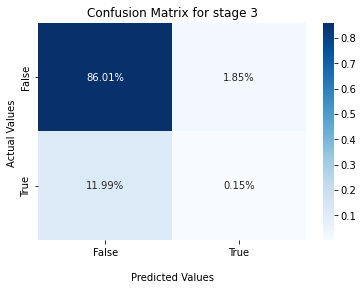

In [163]:
cm = confusion_matrix(label,label_2)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 3');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [164]:
time_label["pred_2"] = label_2

In [165]:
att_p2 = time_label[time_label['attack #'].isin([6,24,29])]

In [166]:
found = []
for i in range(len(att_p2)):
  if (att_p2.iloc[i]["pred_2"] == 1) & (att_p2.iloc[i]["label"] == 1):
    found.append(att_p2.iloc[i]["attack #"])
print(np.unique(found))

[6]


In [167]:
print(metrics.classification_report(att_p2.label,att_p2.pred_2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.28      0.43       638

    accuracy                           0.28       638
   macro avg       0.50      0.14      0.22       638
weighted avg       1.00      0.28      0.43       638



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


##Stage P3

In [168]:
t3 = np.percentile(norm_test_scores[2],95)

In [169]:
t3

0.044402501434087756

In [170]:
label_3 = pred_labels_timewindow(norm_test_scores[2],t3,time_window)

In [171]:
print(metrics.classification_report(label,label_3))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93    395298
           1       0.37      0.06      0.10     54621

    accuracy                           0.87    449919
   macro avg       0.62      0.52      0.52    449919
weighted avg       0.82      0.87      0.83    449919



[[389591   5707]
 [ 51329   3292]]


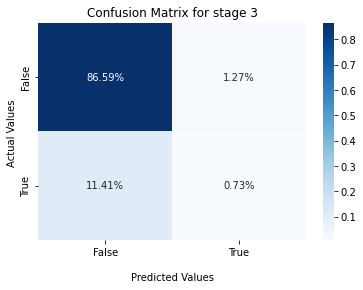

In [172]:
cm = confusion_matrix(label,label_3)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 3');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [173]:
time_label["pred_3"] = label_3

In [174]:
att_p3 = time_label[time_label['attack #'].isin([7,8,13,14,16,17,23,26,27,28,32,41])]

In [175]:
found = []
for i in range(len(att_p3)):
  if (att_p3.iloc[i]["pred_3"] == 1) & (att_p3.iloc[i]["label"] == 1):
    found.append(att_p3.iloc[i]["attack #"])
print(np.unique(found))

[ 7  8 14 16 17 23 26 28 41]


In [176]:
print(metrics.classification_report(att_p3.label,att_p3.pred_3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.07      0.13     43368

    accuracy                           0.07     43368
   macro avg       0.50      0.03      0.06     43368
weighted avg       1.00      0.07      0.13     43368



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


##Stage P4

In [177]:
t4 = np.percentile(norm_test_scores[3],95)

In [178]:
t4

11470.9233203125

In [179]:
label_4 = pred_labels_timewindow(norm_test_scores[3],t4,time_window)

In [180]:
print(metrics.classification_report(label,label_4))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95    395298
           1       0.99      0.16      0.28     54621

    accuracy                           0.90    449919
   macro avg       0.94      0.58      0.61    449919
weighted avg       0.91      0.90      0.86    449919



[[395195    103]
 [ 45725   8896]]


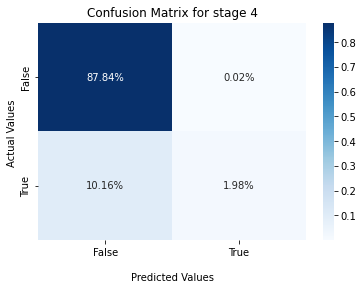

In [181]:
cm = confusion_matrix(label,label_4)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 4');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [182]:
time_label["pred_4"] = label_4

In [183]:
att_p4 = time_label[time_label['attack #'].isin([10,11,22,25,31,38,39,40])]

In [184]:
found = []
for i in range(len(att_p4)):
  if (att_p4.iloc[i]["pred_4"] == 1) & (att_p4.iloc[i]["label"] == 1):
    found.append(att_p4.iloc[i]["attack #"])
print(np.unique(found))

[10 11 40]


In [185]:
print(metrics.classification_report(att_p4.label,att_p4.pred_4))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.26      0.41      3142

    accuracy                           0.26      3142
   macro avg       0.50      0.13      0.21      3142
weighted avg       1.00      0.26      0.41      3142



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


##Stage P5

In [186]:
t5 = np.percentile(norm_test_scores[4],95)

In [187]:
t5

128924.625

In [188]:
label_5 = pred_labels_timewindow(norm_test_scores[4],t5,time_window)

In [189]:
print(metrics.classification_report(label,label_5))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95    395298
           1       0.99      0.16      0.28     54621

    accuracy                           0.90    449919
   macro avg       0.94      0.58      0.61    449919
weighted avg       0.91      0.90      0.86    449919



[[395218     80]
 [ 45681   8940]]


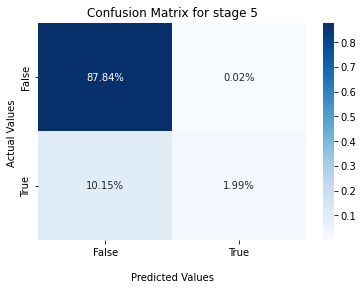

In [190]:
cm = confusion_matrix(label,label_5)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 5');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [191]:
time_label["pred_5"] = label_5

In [192]:
att_p5 = time_label[time_label['attack #'].isin([4,19,20,22,37,38,39])]

In [193]:
found = []
for i in range(len(att_p5)):
  if (att_p5.iloc[i]["pred_5"] == 1) & (att_p5.iloc[i]["label"] == 1):
    found.append(att_p5.iloc[i]["attack #"])
print(np.unique(found))

[]


In [194]:
print(metrics.classification_report(att_p5.label,att_p5.pred_5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    2658.0

    accuracy                           0.00    2658.0
   macro avg       0.00      0.00      0.00    2658.0
weighted avg       0.00      0.00      0.00    2658.0



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


##Stage P6

due to most of the data has very high error score, we use lower bound instead

In [87]:
pd.DataFrame(norm_test_scores[5]).describe()

,0
count,4.499190e+05
mean,9.878163e-01
std,1.065291e-01
min,4.054336e-07
25%,9.998308e-01
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


In [88]:
t6 = np.percentile(norm_test_scores[5],25)

In [89]:
t6

0.9998307824134827

In [90]:
label_6 = np.where(norm_test_scores[5] < t6, 1,0)

In [91]:
print(metrics.classification_report(label,label_6))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92    395298
           1       0.10      0.02      0.04     54621

    accuracy                           0.85    449919
   macro avg       0.49      0.50      0.48    449919
weighted avg       0.78      0.85      0.81    449919



[[383369  11929]
 [ 53364   1257]]


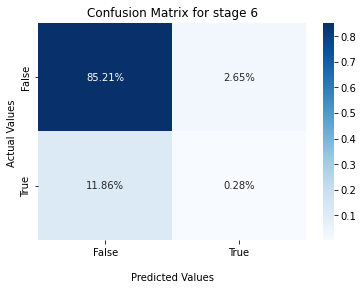

In [92]:
cm = confusion_matrix(label,label_6)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 6');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [93]:
time_label["pred_6"] = label_6

In [94]:
att_p6 = time_label[time_label['attack #'].isin([23])]

In [95]:
found = []
for i in range(len(att_p6)):
  if (att_p6.iloc[i]["pred_6"] == 1) & (att_p6.iloc[i]["label"] == 1):
    found.append(att_p6.iloc[i]["attack #"])
print(np.unique(found))

[23]


In [96]:
print(metrics.classification_report(att_p6.label,att_p6.pred_6))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.03      0.06       697

    accuracy                           0.03       697
   macro avg       0.50      0.02      0.03       697
weighted avg       1.00      0.03      0.06       697



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  0   0]
 [674  23]]


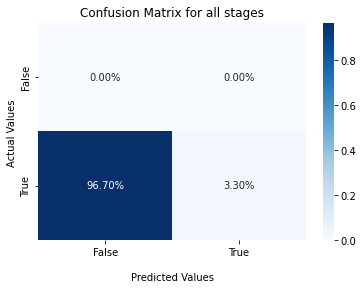

In [97]:
cm = confusion_matrix(att_p6.label,att_p6.pred_6)

print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for all stages');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

##Attack found

In [196]:
time_label['pred'] = np.where((time_label['pred_1'] ==1) | 
                              (time_label['pred_2'] ==1) |
                              (time_label['pred_3'] ==1) |
                              (time_label['pred_4'] ==1) |
                              (time_label['pred_5'] ==1) |
                              (time_label['pred_6'] ==1), 1, 0)


In [207]:
time_label[time_label["label"] == 1].tail(5)

,Timestamp,label,attack #,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred,found
445186,2016-02-01 13:41:07,1,0,0,0,1,0,0,0,1,1
445187,2016-02-01 13:41:08,1,0,0,0,1,0,0,0,1,1
445188,2016-02-01 13:41:09,1,0,0,0,1,0,0,0,1,1
445189,2016-02-01 13:41:10,1,0,0,0,1,0,0,0,1,1
445190,2016-02-01 13:41:11,1,0,0,0,1,0,0,0,1,1


In [200]:
time_label['found'] = 0
t = 100
for i in range(0,len(time_label)-t):
  if ((time_label['pred'][i:i+t]) == 1).all():
    time_label['found'][i:i+t] = 1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [198]:
found = []
for i in range(len(time_label)):
  if (time_label.iloc[i]["found"] == 1) & (time_label.iloc[i]["label"] == 1):
    found.append(time_label.iloc[i]["attack #"])
print(np.unique(found))

[ 0  1  2  3  6  7  8 10 11 14 16 17 19 21 23 24 25 26 27 28 30 31 33 34
 35 36 37 38 40 41]


In [199]:
len(np.unique(found))-1 #remove 0

29

In [203]:
print(metrics.classification_report(time_label.label,time_label.found))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94    395298
           1       0.60      0.42      0.49     54621

    accuracy                           0.90    449919
   macro avg       0.76      0.69      0.72    449919
weighted avg       0.88      0.90      0.89    449919



In [204]:
cm = confusion_matrix(time_label.label,time_label.found)

print(cm)

[[379642  15656]
 [ 31577  23044]]


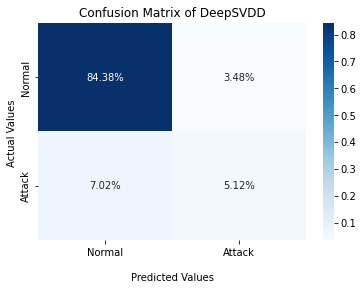

In [311]:
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix of DeepSVDD');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Normal','Attack'])
ax.yaxis.set_ticklabels(['Normal','Attack'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [209]:
att_found = np.unique(found)[1:]
att_found

array([ 1,  2,  3,  6,  7,  8, 10, 11, 14, 16, 17, 19, 21, 23, 24, 25, 26,
       27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41])

###Find explanation for un-detected attack

In [ ]:
#att no.4 happend in process 5
id_a = 3
t_add = 300
att_score = norm_test_scores[4][idx_start[id_a]-t_add:idx_end[id_a]+t_add]

plt.figure(figsize=(8,4))
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score, label='Error score from P1')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), [t5]*len(att_score), label=f'Threshold at {np.round(t1,2)}')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['MV504'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='MV504')
# plt.vlines(idx_start[id_a], ymin=-0.5, ymax=0.8)
# plt.vlines(idx_end[id_a], ymin=-0.5, ymax=0.8)
plt.title("Attack no.4")
plt.fill_between(np.arange(idx_start[id_a]-20,idx_end[id_a]+11), [-0.05,0.3]*(420//2), alpha=0.3, 
                 color = 'pink')
plt.legend()

In [296]:
test_scale.columns

Index(['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202',
       'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205',
       'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303',
       'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401',
       'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504',
       'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603'],
      dtype='object')

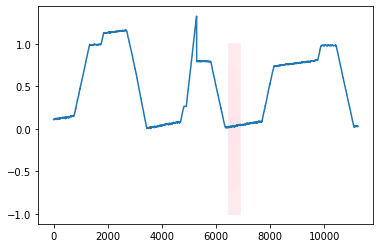

In [288]:
plt.plot(np.arange(len(test_scale['LIT101'])//40),test_scale['LIT101'][:len(test_scale['LIT101'])//40])
plt.fill_between(np.arange(idx_start[3]-20,idx_end[3]+11), [-1,1]*(420//2), alpha=0.3, 
                 color = 'pink')

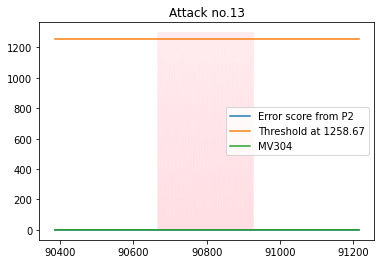

In [298]:
#att no.13 happend in process 2
id_a = 9
t_add = 300
att_score = norm_test_scores[1][idx_start[id_a]-t_add:idx_end[id_a]+t_add]

plt.figure(figsize=(6,4))
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score, label='Error score from P2')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), [t2]*len(att_score), label=f'Threshold at {np.round(t2,2)}')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['MV304'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='MV304')
# plt.vlines(idx_start[id_a], ymin=-0.5, ymax=0.8)
# plt.vlines(idx_end[id_a], ymin=-0.5, ymax=0.8)
plt.title("Attack no.13")
plt.fill_between(np.arange(idx_start[id_a]-20,idx_end[id_a]+10), [-0.05,1300]*(262//2), alpha=0.3, 
                 color = 'pink')
plt.legend()

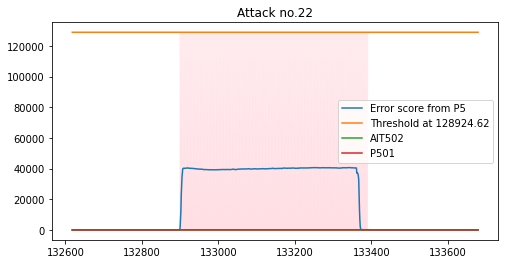

In [247]:
#att no.22 happend in process 4,5
id_a = 16
t_add = 300
# att_score = norm_test_scores[3][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
att_score2 = norm_test_scores[4][idx_start[id_a]-t_add:idx_end[id_a]+t_add]


plt.figure(figsize=(8,4))
# plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score, label='Error score from P4')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score2, label='Error score from P5')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), [t5]*len(att_score), label=f'Threshold at {np.round(t5,2)}')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['AIT502'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='AIT502')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['P501'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='P501')
# plt.vlines(idx_start[id_a], ymin=-0.5, ymax=0.8)
# plt.vlines(idx_end[id_a], ymin=-0.5, ymax=0.8)
plt.title("Attack no.22")
plt.fill_between(np.arange(idx_start[id_a]-20,idx_end[id_a]+10), [-0,t5+1]*(492//2), alpha=0.3, 
                 color = 'pink')
plt.legend()

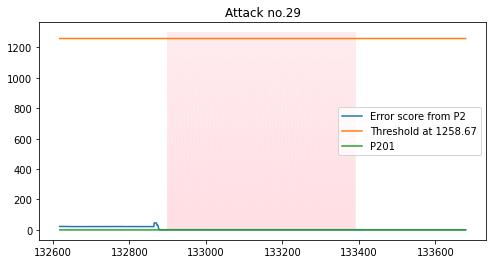

In [252]:
#att no.29 happend in process 2
id_a = 16
t_add = 300
att_score = norm_test_scores[1][idx_start[id_a]-t_add:idx_end[id_a]+t_add]

plt.figure(figsize=(8,4))
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score, label='Error score from P2')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), [t2]*len(att_score), label=f'Threshold at {np.round(t2,2)}')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['P201'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='P201')
plt.title("Attack no.29")
plt.fill_between(np.arange(idx_start[id_a]-20,idx_end[id_a]+10), [-0.05,1300]*(492//2), alpha=0.3, 
                 color = 'pink')
plt.legend()

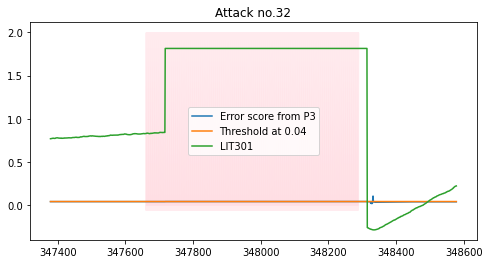

In [261]:
#att no.32 happend in process 3
id_a = 26
t_add = 300
att_score = norm_test_scores[2][idx_start[id_a]-t_add:idx_end[id_a]+t_add]

plt.figure(figsize=(8,4))
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score, label='Error score from P3')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), [t3]*len(att_score), label=f'Threshold at {np.round(t3,2)}')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['LIT301'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='LIT301')
plt.title("Attack no.32")
plt.fill_between(np.arange(idx_start[id_a]-20,idx_end[id_a]+10), [-0.05,2]*(630//2), alpha=0.3, 
                 color = 'pink')
plt.legend()

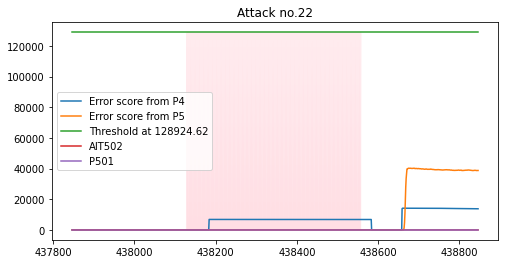

In [268]:
#att no.39 happend in process 2
id_a = 33
t_add = 300
att_score = norm_test_scores[3][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
att_score2 = norm_test_scores[4][idx_start[id_a]-t_add:idx_end[id_a]+t_add]


plt.figure(figsize=(8,4))
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score, label='Error score from P4')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score2, label='Error score from P5')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), [t5]*len(att_score), label=f'Threshold at {np.round(t5,2)}')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['FIT401'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='AIT502')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['AIT502'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='P501')
# plt.vlines(idx_start[id_a], ymin=-0.5, ymax=0.8)
# plt.vlines(idx_end[id_a], ymin=-0.5, ymax=0.8)
plt.title("Attack no.22")
plt.fill_between(np.arange(idx_start[id_a]-20,idx_end[id_a]+10), [-0,t5+1]*(430//2), alpha=0.3, 
                 color = 'pink')
plt.legend()

#XAI

In [106]:
!pip install shap --quiet
!pip install lime --quiet
!pip install alibi[tensorflow] --quiet

     |████████████████████████████████| 569 kB 7.1 MB/s 
     |████████████████████████████████| 275 kB 8.1 MB/s 
     |████████████████████████████████| 445 kB 8.4 MB/s 
     |████████████████████████████████| 60 kB 8.1 MB/s 
     |████████████████████████████████| 4.7 MB 56.7 MB/s 
     |████████████████████████████████| 98.5 MB 1.2 MB/s 
     |████████████████████████████████| 6.6 MB 59.2 MB/s 
     |████████████████████████████████| 101 kB 12.3 MB/s 


In [107]:
import shap
import lime
import lime.lime_tabular
from lime import submodular_pick
from alibi.explainers import ALE
from alibi.explainers import IntegratedGradients

In [ ]:
X_train_summary = shap.kmeans(train_scale, 100)

In [125]:
print(model.decision_function)

<bound method DeepSVDD.decision_function of DeepSVDD(batch_size=64,
     c=array([0.14351, 0.     , 0.1775 , 0.1    , 0.1    , 0.     , 0.     ,
       0.1    , 0.1    , 0.     , 0.1    , 0.1    , 0.1    , 0.     ,
       0.13826, 0.1    , 0.1    , 0.     , 0.     , 0.37501, 0.37783,
       0.1    , 0.27106, 0.20794, 0.     , 0.1    , 0.1    , 0.27419,
       0.18227, 0.1    , 0.     , 0.1    ], dtype=float32),
     contamination=0.1, dropout_rate=0.2, epochs=100,
     hidden_activation='relu', hidden_neurons=[64, 32], l2_regularizer=0.1,
     optimizer='adam', output_activation='sigmoid', preprocessing=False,
     random_state=None, use_ae=False, validation_size=0.1, verbose=1)>


In [148]:
shap_explainer = shap.KernelExplainer(model=model.decision_function, data=X_train_summary)

In [131]:
ale = ALE(model.decision_function, feature_names=train_scale.columns)
lm = lime.lime_tabular.LimeTabularExplainer(X_train_summary.data, feature_names=train_scale.columns,
                                                   verbose=True, mode='regression')
ig  = IntegratedGradients(model.model_,
                          layer=None,
                          target_fn=None,
                          method="gausslegendre",
                          n_steps=50,
                          internal_batch_size=100)

## case study att no.24
P203,P205 are attack point

In [305]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 24)].index.values
n = 100 if len(idx) > 100 else len(idx)
sample = test_scale[idx[0]:idx[-1]].sample(n = n)

In [306]:
shap_value = shap_explainer.shap_values(X=sample, nsamples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

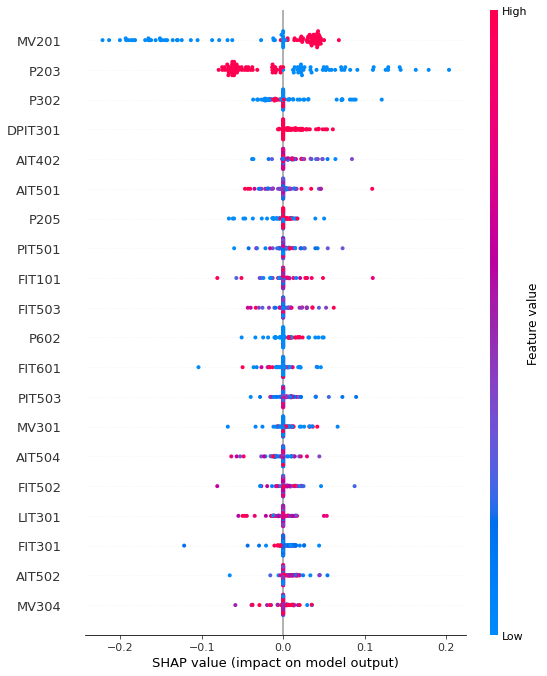

In [307]:
shap.initjs()
shap.summary_plot(shap_value, sample)

Requested sample size larger than
                              size of input data. Using all data


Intercept 0.21647278775143824
Prediction_local [0.09536414]
Right: 0.024310477
Intercept 0.17827191805801065
Prediction_local [0.12077081]
Right: 0.019416042
Intercept 0.1275681650003924
Prediction_local [0.1352279]
Right: 0.015683146
Intercept 0.21065639958505888
Prediction_local [0.08392901]
Right: 0.004950449
Intercept 0.22412378533025204
Prediction_local [0.06725913]
Right: 0.021025531
Intercept 0.1610703825865073
Prediction_local [0.12106642]
Right: 0.021836769
Intercept 0.19020264677418983
Prediction_local [0.11228837]
Right: 0.027171465
Intercept 0.1580617557598103
Prediction_local [0.16112966]
Right: 0.017554197
Intercept 0.1154732982414884
Prediction_local [0.13850737]
Right: 0.0068744523
Intercept 0.1508595947042713
Prediction_local [0.14584689]
Right: 0.023152545
Intercept 0.16322329848288003
Prediction_local [0.14615596]
Right: 0.019826384
Intercept 0.09831631777931626
Prediction_local [0.23213573]
Right: 0.030499108
Intercept 0.057317773207184244
Prediction_local [0.232582

[<Figure size 432x288 with 1 Axes>]

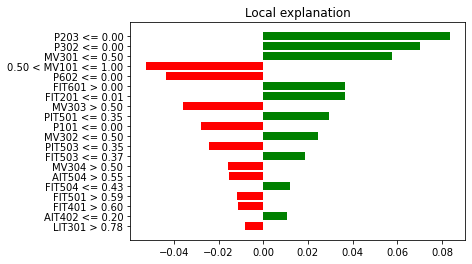

In [308]:
sp_obj = submodular_pick.SubmodularPick(lm, sample.values, model.decision_function, num_features=20,num_exps_desired=1)
[exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations]

Text(0.5, 0, 'feature')

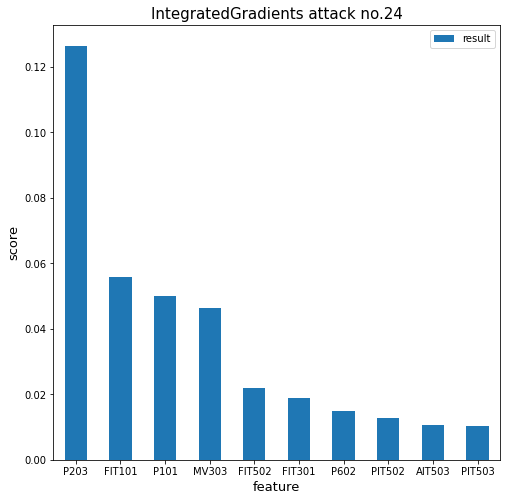

In [319]:
ig  = IntegratedGradients(model.model_,
                          layer=None,
                          target_fn=None,
                          method="gausslegendre",
                          n_steps=50,
                          internal_batch_size=100)
ig_explanation = ig.explain(sample.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample))
attributions = ig_explanation.attributions
ig_result = pd.DataFrame(np.mean(attributions[0],axis=0), index= train_scale.columns, columns = ["result"])
ig_plot = ig_result.sort_values(by = ["result"], ascending=False)[0:10]
ig_plot.plot.bar(rot=0,figsize=(8, 8))
plt.title("IntegratedGradients attack no.24",size=15)
plt.ylabel("score",size=13)
plt.xlabel("feature",size=13)

In [320]:
exp_ale = ale.explain(sample.to_numpy())

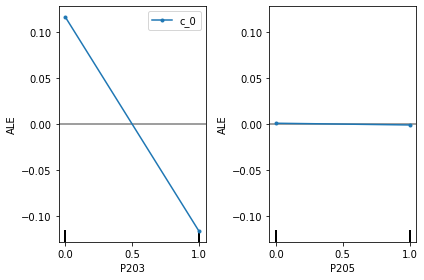

In [323]:
from alibi.explainers import plot_ale
plot_ale(exp_ale, features = ['P203','P205']);

##find all explaination for anomaly detected

In [324]:
def explain_all_attack(att_found,test_scale):
  shap_values = []
  limes = []
  ales = []
  igs = []
  for i in att_found:
    idx = time_label[(time_label["attack #"] == i)].index.values
    n = 100 if len(idx) > 100 else len(idx)
    sample = test_scale[idx[0]:idx[-1]].sample(n = n)
    #shap explainer
    shap_value = shap_explainer.shap_values(X=sample, nsamples=100)
    shap_values.append(np.mean(shap_value,axis=0))

    #lime
    sp_obj = submodular_pick.SubmodularPick(lm, sample.values, model.decision_function, num_features=20,num_exps_desired=1)
    limes.append(sp_obj.sp_explanations[0].as_list())

    #ale
    exp_ale = ale.explain(sample.to_numpy())
    ales.append([np.mean(e) for e in exp_ale.ale_values])

    #IG
    ig_explanation = ig.explain(sample.to_numpy(),
                         baselines=None,
                         target=[0]*len(sample))
    igs.append(np.mean(ig_explanation.attributions[0],axis=0))

    print(f"---------------------------------- finish XAI attack no {i} ----------------------------")
  
  return shap_values,limes,ales,igs

In [ ]:
shap_values,limes,ales,igs = explain_all_attack(att_found,test_scale)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.21533220624211435
Prediction_local [0.04957931]
Right: 0.0064633214
Intercept 0.18147666210593513
Prediction_local [0.08066869]
Right: 0.0074727684
Intercept 0.17986051147852294
Prediction_local [0.09737122]
Right: 0.0075641023
Intercept 0.20495306325983303
Prediction_local [0.11211706]
Right: 0.0073064384
Intercept 0.1988568422914146
Prediction_local [0.04866437]
Right: 0.0074202013


In [ ]:
#save result
path = '/content/drive/MyDrive/Data_sci_Project/XAI_result/'

xai_re = {'shap_values':shap_values,"limes":limes,"ales":ales,"igs":igs}

In [ ]:
import pickle
with open(path+'deep_svdd_xai.pkl', 'wb') as fid:
     pickle.dump(xai_re, fid)